# Conversational agent

## Agents are:
- a combination of LLM and codes.
- LLM reason about what steps to take and call for action


## Agent loop:
- Choose a loop to use
- observe the output of the tools
- repeat until a stopping condition is met


## stopping condistion can be:
- LLM determined
- Hardcoded rules

### in this notebook, we will:
1. build some tools;
2. write your own agent loop using LCEL;
3. Utilize agent_execuator which:
 - implements the agent loop
 - adds error handling, early stopping, tracing... etc


In [1]:
!pip install langchain openai python-dotenv wikipedia requests
!pip install panel
!pip install tiktoken
!pip install pypdf
!pip install chromadb
!pip install pypdf
!pip install langchain_community

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 905.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.6/375.6 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.9/399.9 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.7 MB/s eta 0:00:00
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11679 sha256=0aff3afe6966bb0ab9db181229bb7aa0b09c8a35330bcfe893900fe9ec1cd011
  Stored

In [2]:
import os
import openai

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']
OPENAI_API_KEY = openai.api_key

In [3]:
from langchain.tools import tool

In [4]:
import requests
from pydantic import BaseModel, Field
import datetime

# Define the input schema
class OpenMeteoInput(BaseModel):
    latitude: float = Field(..., description="Latitude of the location to fetch weather data for")
    longitude: float = Field(..., description="Longitude of the location to fetch weather data for")

@tool(args_schema=OpenMeteoInput)
def get_current_temperature(latitude: float, longitude: float) -> dict:
    """Fetch current temperature for given coordinates."""

    BASE_URL = "https://api.open-meteo.com/v1/forecast"

    # Parameters for the request
    params = {
        'latitude': latitude,
        'longitude': longitude,
        'hourly': 'temperature_2m',
        'forecast_days': 1,
    }

    # Make the request
    response = requests.get(BASE_URL, params=params)

    if response.status_code == 200:
        results = response.json()
    else:
        raise Exception(f"API Request failed with status code: {response.status_code}")

    current_utc_time = datetime.datetime.utcnow()
    time_list = [datetime.datetime.fromisoformat(time_str.replace('Z', '+00:00')) for time_str in results['hourly']['time']]
    temperature_list = results['hourly']['temperature_2m']

    closest_time_index = min(range(len(time_list)), key=lambda i: abs(time_list[i] - current_utc_time))
    current_temperature = temperature_list[closest_time_index]

    return f'The current temperature is {current_temperature}°C'

In [5]:
import wikipedia

@tool
def search_wikipedia(query: str) -> str:
    """Run Wikipedia search and get page summaries."""
    page_titles = wikipedia.search(query)
    summaries = []
    for page_title in page_titles[: 3]:
        try:
            wiki_page =  wikipedia.page(title=page_title, auto_suggest=False)
            summaries.append(f"Page: {page_title}\nSummary: {wiki_page.summary}")
        except (
            self.wiki_client.exceptions.PageError,
            self.wiki_client.exceptions.DisambiguationError,
        ):
            pass
    if not summaries:
        return "No good Wikipedia Search Result was found"
    return "\n\n".join(summaries)

In [6]:
tools = [get_current_temperature, search_wikipedia]

In [7]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.tools.render import format_tool_to_openai_function
from langchain.agents.output_parsers import OpenAIFunctionsAgentOutputParser

In [8]:
functions = [format_tool_to_openai_function(f) for f in tools]
model = ChatOpenAI(temperature=0, openai_api_key = openai.api_key).bind(functions=functions)
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are helpful but sassy assistant"),
    ("user", "{input}"),
])
chain = prompt | model | OpenAIFunctionsAgentOutputParser()

<ipython-input-8-fc5daf57d5ad>:1: LangChainDeprecationWarning: The function `format_tool_to_openai_function` was deprecated in LangChain 0.1.16 and will be removed in 1.0. Use :meth:`~langchain_core.utils.function_calling.convert_to_openai_function()` instead.
  functions = [format_tool_to_openai_function(f) for f in tools]
<ipython-input-8-fc5daf57d5ad>:2: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  model = ChatOpenAI(temperature=0, openai_api_key = openai.api_key).bind(functions=functions)


In [9]:
result = chain.invoke({"input": "what is the weather is sf?"})

In [10]:
result.tool

'get_current_temperature'

In [11]:
result.tool_input

{'latitude': 37.7749, 'longitude': -122.4194}

In [12]:
from langchain.prompts import MessagesPlaceholder
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are helpful but sassy assistant"),
    ("user", "{input}"),
    MessagesPlaceholder(variable_name="agent_scratchpad")
])

In [13]:
chain = prompt | model | OpenAIFunctionsAgentOutputParser()

In [14]:
result1 = chain.invoke({
    "input": "what is the weather is sf?",
    "agent_scratchpad": []
})

In [15]:
result1.tool

'get_current_temperature'

In [16]:
observation = get_current_temperature(result1.tool_input)

<ipython-input-16-fa9bb063a359>:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  observation = get_current_temperature(result1.tool_input)


In [17]:
observation

'The current temperature is 20.9°C'

In [18]:
type(result1)

langchain_core.agents.AgentActionMessageLog

In [19]:
from langchain.agents.format_scratchpad import format_to_openai_functions

In [20]:
result1.message_log

[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"latitude":37.7749,"longitude":-122.4194}', 'name': 'get_current_temperature'}}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 112, 'total_tokens': 137, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'function_call', 'logprobs': None}, id='run-9fdca6a9-657f-4886-a4d1-d9b90c7b638b-0')]

In [21]:
format_to_openai_functions([(result1, observation), ])

[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"latitude":37.7749,"longitude":-122.4194}', 'name': 'get_current_temperature'}}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 112, 'total_tokens': 137, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'function_call', 'logprobs': None}, id='run-9fdca6a9-657f-4886-a4d1-d9b90c7b638b-0'),
 FunctionMessage(content='The current temperature is 20.9°C', additional_kwargs={}, response_metadata={}, name='get_current_temperature')]

In [22]:
result2 = chain.invoke({
    "input": "what is the weather is sf?",
    "agent_scratchpad": format_to_openai_functions([(result1, observation)])
})

In [23]:
result2

AgentFinish(return_values={'output': 'The current temperature in San Francisco is 20.9°C.'}, log='The current temperature in San Francisco is 20.9°C.')

In [24]:
from langchain.schema.agent import AgentFinish
def run_agent(user_input):
    intermediate_steps = []
    while True:
        result = chain.invoke({
            "input": user_input,
            "agent_scratchpad": format_to_openai_functions(intermediate_steps)
        })
        if isinstance(result, AgentFinish):
            return result
        tool = {
            "search_wikipedia": search_wikipedia,
            "get_current_temperature": get_current_temperature,
            # "get_currency": convert_currency

        }[result.tool]
        observation = tool.run(result.tool_input)
        intermediate_steps.append((result, observation))

In [25]:
from langchain.schema.runnable import RunnablePassthrough
agent_chain = RunnablePassthrough.assign(
    agent_scratchpad= lambda x: format_to_openai_functions(x["intermediate_steps"])
) | chain

In [26]:
def run_agent(user_input):
    intermediate_steps = []
    while True:
        result = agent_chain.invoke({
            "input": user_input,
            "intermediate_steps": intermediate_steps
        })
        if isinstance(result, AgentFinish):
            return result
        tool = {
            "search_wikipedia": search_wikipedia,
            "get_current_temperature": get_current_temperature,
            # "get_currency": convert_currency
        }[result.tool]
        observation = tool.run(result.tool_input)
        intermediate_steps.append((result, observation))

In [27]:
run_agent("what is the weather is sf?")

AgentFinish(return_values={'output': 'The current temperature in San Francisco is 20.9°C.'}, log='The current temperature in San Francisco is 20.9°C.')

In [28]:
run_agent("what is langchain?")

AgentFinish(return_values={'output': 'LangChain is a framework designed to simplify the creation of applications using large language models (LLMs). It is a language model integration framework with use-cases including document analysis and summarization, chatbots, and code analysis.'}, log='LangChain is a framework designed to simplify the creation of applications using large language models (LLMs). It is a language model integration framework with use-cases including document analysis and summarization, chatbots, and code analysis.')

In [29]:
run_agent("hi!")

AgentFinish(return_values={'output': 'Well, hello there! How can I assist you today?'}, log='Well, hello there! How can I assist you today?')

In [30]:
run_agent("Tell me something about Demi Moore? Also tell me which tool are you using to get the answer and the source where you answer is from.")

AgentFinish(return_values={'output': 'I found information about Demi Moore. She is an American actress who first gained attention on daytime television before becoming a film star in the mid-1980s. By the mid-1990s, she was the world\'s highest-paid actress. Moore\'s career includes roles in films like "Ghost," "A Few Good Men," and "Indecent Proposal." She has received nominations for a Primetime Emmy Award and three Golden Globe Awards. Moore has been married three times and has three daughters with Bruce Willis.\n\nThe tool I used to find this information is Wikipedia search. The source of this information is Wikipedia.'}, log='I found information about Demi Moore. She is an American actress who first gained attention on daytime television before becoming a film star in the mid-1980s. By the mid-1990s, she was the world\'s highest-paid actress. Moore\'s career includes roles in films like "Ghost," "A Few Good Men," and "Indecent Proposal." She has received nominations for a Primetim

In [31]:
# this is before the currency converter was introduced
run_agent("How much is 100 CNY worth in USD? Can you tell me the tool and the source as well?")

AgentFinish(return_values={'output': 'The tool for currency conversion is not explicitly mentioned in the search results. However, you can use online currency converters or financial websites to check the current exchange rate between Chinese Yuan (CNY) and US Dollar (USD).\n\nThe source for the currency conversion information can be obtained from financial websites, currency exchange platforms, or official financial institutions that provide real-time exchange rate data.\n\nIf you need further assistance or have any other questions, feel free to ask!'}, log='The tool for currency conversion is not explicitly mentioned in the search results. However, you can use online currency converters or financial websites to check the current exchange rate between Chinese Yuan (CNY) and US Dollar (USD).\n\nThe source for the currency conversion information can be obtained from financial websites, currency exchange platforms, or official financial institutions that provide real-time exchange rate d

## Put the tools and run_agent together:

## The essential steps you need to use tools and agents are:

1. define the functions.
2. tools = [get_current_temperature, search_wikipedia, convert_currency]

In [32]:
# introducing a new tool
class CurrencyConversionInput(BaseModel):
    from_currency: str = Field(..., description="the currency to convert from, USD or CNY)")
    to_currency: str = Field(..., description="the currency to convert to, USD or CNY)")
    amount: float = Field(..., description="he amount of money to convert")

@tool(args_schema=CurrencyConversionInput)
def convert_currency(from_currency: str, to_currency: str, amount: float) -> str:
  # must have a docstring if it does not have description....
    """Convert currency from one type to another using an exchange rate API."""

    BASE_URL = f"https://api.exchangerate-api.com/v4/latest/{from_currency}"

    response = requests.get(BASE_URL)

    if response.status_code == 200:
        data = response.json()
        exchange_rate = data['rates'][to_currency]
        converted_amount = amount * exchange_rate
        return f"{amount} {from_currency} is equal to {converted_amount:.2f} {to_currency}."
    else:
        raise Exception(f"API Request failed with status code: {response.status_code}")

In [33]:
tools = [get_current_temperature, search_wikipedia, convert_currency]

In [34]:
# 3.
from langchain.agents.format_scratchpad import format_to_openai_functions
from langchain.prompts import MessagesPlaceholder
from langchain.schema.agent import AgentFinish
from langchain.schema.runnable import RunnablePassthrough

# basic
tools = [get_current_temperature, search_wikipedia, convert_currency]
functions = [format_tool_to_openai_function(f) for f in tools]
model = ChatOpenAI(temperature=0, openai_api_key = OPENAI_API_KEY).bind(functions=functions)
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are helpful but sassy assistant"),
    ("user", "{input}"),
])
# first chain
chain = prompt | model | OpenAIFunctionsAgentOutputParser()
# result = chain.invoke({"input": "what is the weather in SF?"})
# clean_result = format_output(result)
# print("from first chain, result:", clean_result)

result = chain.invoke({"input": "what is the weather is sf?"})
print("from first chain, result:", result)

# with agent_scrtchpad, second chain
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are helpful but sassy assistant"),
    ("user", "{input}"),
    MessagesPlaceholder(variable_name="agent_scratchpad")
])

chain = prompt | model | OpenAIFunctionsAgentOutputParser()

result1 = chain.invoke({
    "input": "what is the weather is sf?",
    "agent_scratchpad": []
})
observation = get_current_temperature(result1.tool_input)
format_to_openai_functions([(result1, observation), ])
result2 = chain.invoke({
    "input": "what is the weather is sf?",
    "agent_scratchpad": format_to_openai_functions([(result1, observation)])
})
print("from second chain and agent_scratchpad, result:", result2)


def run_agent(user_input):
    intermediate_steps = []
    while True:
        result = chain.invoke({
            "input": user_input,
            "agent_scratchpad": format_to_openai_functions(intermediate_steps)
        })
        if isinstance(result, AgentFinish):
            print("checking")
            return result
        tool = {
            "search_wikipedia": search_wikipedia,
            "get_current_temperature": get_current_temperature,
            "convert_currency": convert_currency
        }[result.tool]
        observation = tool.run(result.tool_input)
        intermediate_steps.append((result, observation))

agent_chain = RunnablePassthrough.assign(
    agent_scratchpad= lambda x: format_to_openai_functions(x["intermediate_steps"])
) | chain



from first chain, result: tool='get_current_temperature' tool_input={'latitude': 37.7749, 'longitude': -122.4194} log="\nInvoking: `get_current_temperature` with `{'latitude': 37.7749, 'longitude': -122.4194}`\n\n\n" message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"latitude":37.7749,"longitude":-122.4194}', 'name': 'get_current_temperature'}}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 183, 'total_tokens': 208, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'function_call', 'logprobs': None}, id='run-d57a65c0-d838-4196-a606-1a48b7d2ebc0-0')]
from second chain and agent_scratchpad, result: return_values={'output': 'The current temperature in San Francisco is 20.9°C.'} log='The current temperature in San Francisco is 20.9°C.'


In [35]:
run_agent("What is 1000 Euro worth in USD?")
# remember to add the new function to the list called tool

checking


AgentFinish(return_values={'output': '1000 Euro is worth 1110 USD.'}, log='1000 Euro is worth 1110 USD.')

In [36]:
def run_agent(user_input):
    intermediate_steps = []
    while True:
        result = agent_chain.invoke({
            "input": user_input,
            "intermediate_steps": intermediate_steps
        })
        if isinstance(result, AgentFinish):
            return result
        tool = {
            "search_wikipedia": search_wikipedia,
            "get_current_temperature": get_current_temperature,
            "convert_currency": convert_currency
        }[result.tool]
        observation = tool.run(result.tool_input)
        intermediate_steps.append((result, observation))

In [37]:
run_agent("What is 1000 Euro worth in USD? and tell me which tool did you use? and tell me the source you get the information from?")

AgentFinish(return_values={'output': 'I used the currency conversion tool to convert 1000 Euro to USD. The information was sourced from an exchange rate API.'}, log='I used the currency conversion tool to convert 1000 Euro to USD. The information was sourced from an exchange rate API.')

In [38]:
from langchain.agents import AgentExecutor
agent_executor = AgentExecutor(agent=agent_chain, tools=tools, verbose=True)

In [39]:
agent_executor.invoke({"input": "what is langchain?"})


Invoking: `search_wikipedia` with `{'query': 'Langchain'}`


Page: LangChain
Summary: LangChain is a framework designed to simplify the creation of applications using large language models (LLMs). As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.



Page: Retrieval-augmented generation
Summary: Retrieval augmented generation (RAG) is a type of generative artificial intelligence that has information retrieval capabilities. It modifies interactions with a large language model (LLM) so that the model responds to user queries with reference to a specified set of documents, using this information in preference to information drawn from its own vast, static training data. This allows LLMs to use domain-specific and/or updated information.  
Use cases include providing chatbot access to internal company data, or giving factual information only f

{'input': 'what is langchain?',
 'output': 'I couldn\'t find specific information on "Langchain," but I did find information on "LangChain," which is a framework designed to simplify the creation of applications using large language models (LLMs). It is used for tasks such as document analysis, chatbots, and code analysis.'}

In [40]:
agent_executor.invoke({"input": "my name is bob"})

Nice to meet you, Bob! How can I assist you today?

> Finished chain.


{'input': 'my name is bob',
 'output': 'Nice to meet you, Bob! How can I assist you today?'}

In [41]:
agent_executor.invoke({"input": "what is my name"})
# so the agent does not remeber anything here. hmmm

I'm sorry, I don't have access to your personal information like your name. How can I assist you today?

> Finished chain.


{'input': 'what is my name',
 'output': "I'm sorry, I don't have access to your personal information like your name. How can I assist you today?"}

In [42]:
agent_executor.invoke({"input": "tell me something about Demi Moore? Don't think the director really paid attention to \
recent public discussion regarding Ms.Moore's \
relationship with plastic surgery. Do you think 'The Substance (Movie)' is one of Demi's finest performances in recent years?"})


Invoking: `search_wikipedia` with `{'query': 'Demi Moore'}`


Page: Demi Moore
Summary: Demi Gene Moore ( də-MEE; née Guynes; born November 11, 1962) is an American actress. She first gained attention on daytime television before breaking out as a film star in the mid-1980s. By the mid-1990s, she was the world's highest-paid actress. Though her career saw a downturn by the end of that decade, she remains a subject of substantial media interest. Moore's accolades include nominations for a Primetime Emmy Award and three Golden Globe Awards.
A former model, Moore made her film debut in 1981 and joined the cast of the soap opera General Hospital later that year. After departing the show in 1983, she rose to prominence as a member of the Brat Pack with roles in Blame It on Rio (1984), St. Elmo's Fire (1985), and About Last Night... (1986). While the lattermost made Moore a star, she established herself as a bankable performer with Ghost, the highest-grossing film of 1990. She had further b

{'input': "tell me something about Demi Moore? Don't think the director really paid attention to recent public discussion regarding Ms.Moore's relationship with plastic surgery. Do you think 'The Substance (Movie)' is one of Demi's finest performances in recent years?",
 'output': 'Demi Moore is an American actress who first gained attention on daytime television before becoming a film star in the mid-1980s. She was the world\'s highest-paid actress in the mid-1990s and has received nominations for a Primetime Emmy Award and three Golden Globe Awards. Moore has had notable roles in films such as "Ghost," "A Few Good Men," "Indecent Proposal," and "Disclosure."\n\nRegarding "The Substance," it seems that the movie has received renewed critical recognition for Demi Moore\'s starring role in the body horror film. While it may not be her finest performance in recent years, it has garnered positive attention from critics.'}

In [43]:
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are helpful but sassy assistant"),
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{input}"),
    MessagesPlaceholder(variable_name="agent_scratchpad")
])

In [44]:
agent_chain = RunnablePassthrough.assign(
    agent_scratchpad= lambda x: format_to_openai_functions(x["intermediate_steps"])
) | prompt | model | OpenAIFunctionsAgentOutputParser()

In [45]:
from langchain.memory import ConversationBufferMemory
memory = ConversationBufferMemory(return_messages=True,memory_key="chat_history")

In [46]:
agent_executor = AgentExecutor(agent=agent_chain, tools=tools, verbose=True, memory=memory)

In [47]:
agent_executor.invoke({"input": "my name is bob"})

Nice to meet you, Bob! How can I assist you today?

> Finished chain.


{'input': 'my name is bob',
 'chat_history': [HumanMessage(content='my name is bob', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Nice to meet you, Bob! How can I assist you today?', additional_kwargs={}, response_metadata={})],
 'output': 'Nice to meet you, Bob! How can I assist you today?'}

In [48]:
agent_executor.invoke({"input": "whats my name"})

Your name is Bob.

> Finished chain.


{'input': 'whats my name',
 'chat_history': [HumanMessage(content='my name is bob', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Nice to meet you, Bob! How can I assist you today?', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='whats my name', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Your name is Bob.', additional_kwargs={}, response_metadata={})],
 'output': 'Your name is Bob.'}

In [49]:
agent_executor.invoke({"input": "whats the weather in sf?"})


Invoking: `get_current_temperature` with `{'latitude': 37.7749, 'longitude': -122.4194}`


The current temperature is 20.9°CThe current temperature in San Francisco is 20.9°C.

> Finished chain.


{'input': 'whats the weather in sf?',
 'chat_history': [HumanMessage(content='my name is bob', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Nice to meet you, Bob! How can I assist you today?', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='whats my name', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Your name is Bob.', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='whats the weather in sf?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='The current temperature in San Francisco is 20.9°C.', additional_kwargs={}, response_metadata={})],
 'output': 'The current temperature in San Francisco is 20.9°C.'}

### Create a chatbot

In [50]:
# !pip install pdfplumber
# would be a good idead to make the read pdf function work here.

In [60]:
@tool
def create_your_own(query: str) -> str:
    """This function can do whatever you would like once you fill it in """
    print(type(query))
    return query[::-1]

@tool
def reverse_words(query: str) -> str:
    """This function can do whatever you would like once you fill it in """
    print(type(query))
    return query[::-1]

In [63]:
!pip install jupyter_bokeh

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 53.0 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.9
    Uninstalling widgetsnbextension-3.6.9:
      Successfully uninstalled widgetsnbextension-3.6.9
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [61]:
tools = [get_current_temperature, search_wikipedia, reverse_words, convert_currency]

In [64]:
import panel as pn  # GUI
pn.extension()
import panel as pn
import param

class cbfs(param.Parameterized):

    def __init__(self, tools, **params):
        super(cbfs, self).__init__( **params)
        self.panels = []
        self.functions = [format_tool_to_openai_function(f) for f in tools]
        self.model = ChatOpenAI(temperature=0, openai_api_key = OPENAI_API_KEY).bind(functions=self.functions)
        self.memory = ConversationBufferMemory(return_messages=True,memory_key="chat_history")
        self.prompt = ChatPromptTemplate.from_messages([
            ("system", "You are helpful but sassy assistant"),
            MessagesPlaceholder(variable_name="chat_history"),
            ("user", "{input}"),
            MessagesPlaceholder(variable_name="agent_scratchpad")
        ])
        self.chain = RunnablePassthrough.assign(
            agent_scratchpad = lambda x: format_to_openai_functions(x["intermediate_steps"])
        ) | self.prompt | self.model | OpenAIFunctionsAgentOutputParser()
        self.qa = AgentExecutor(agent=self.chain, tools=tools, verbose=False, memory=self.memory)

    def convchain(self, query):
        if not query:
            return
        inp.value = ''
        result = self.qa.invoke({"input": query})
        self.answer = result['output']
        self.panels.extend([
            pn.Row('User:', pn.pane.Markdown(query, width=450)),
            pn.Row('ChatBot:', pn.pane.Markdown(self.answer, width=450, styles={'background-color': '#F6F6F6'}))
        ])
        return pn.WidgetBox(*self.panels, scroll=True)


    def clr_history(self,count=0):
        self.chat_history = []
        return

In [65]:
cb = cbfs(tools)

inp = pn.widgets.TextInput( placeholder='Enter text here…')

conversation = pn.bind(cb.convchain, inp)

tab1 = pn.Column(
    pn.Row(inp),
    pn.layout.Divider(),
    pn.panel(conversation,  loading_indicator=True, height=400),
    pn.layout.Divider(),
)

dashboard = pn.Column(
    pn.Row(pn.pane.Markdown('# QnA_Bot')),
    pn.Tabs(('Conversation', tab1))
)
dashboard

Column
    [0] Row
        [0] Markdown(str)
    [1] Tabs
        [0] Column
            [0] Row
                [0] TextInput(placeholder='Enter text here…')
            [1] Divider()
            [2] ParamFunction(function, _pane=Str, defer_load=False, height=400, loading_indicator=True)
            [3] Divider()

Saving qaBOT.png to qaBOT.png


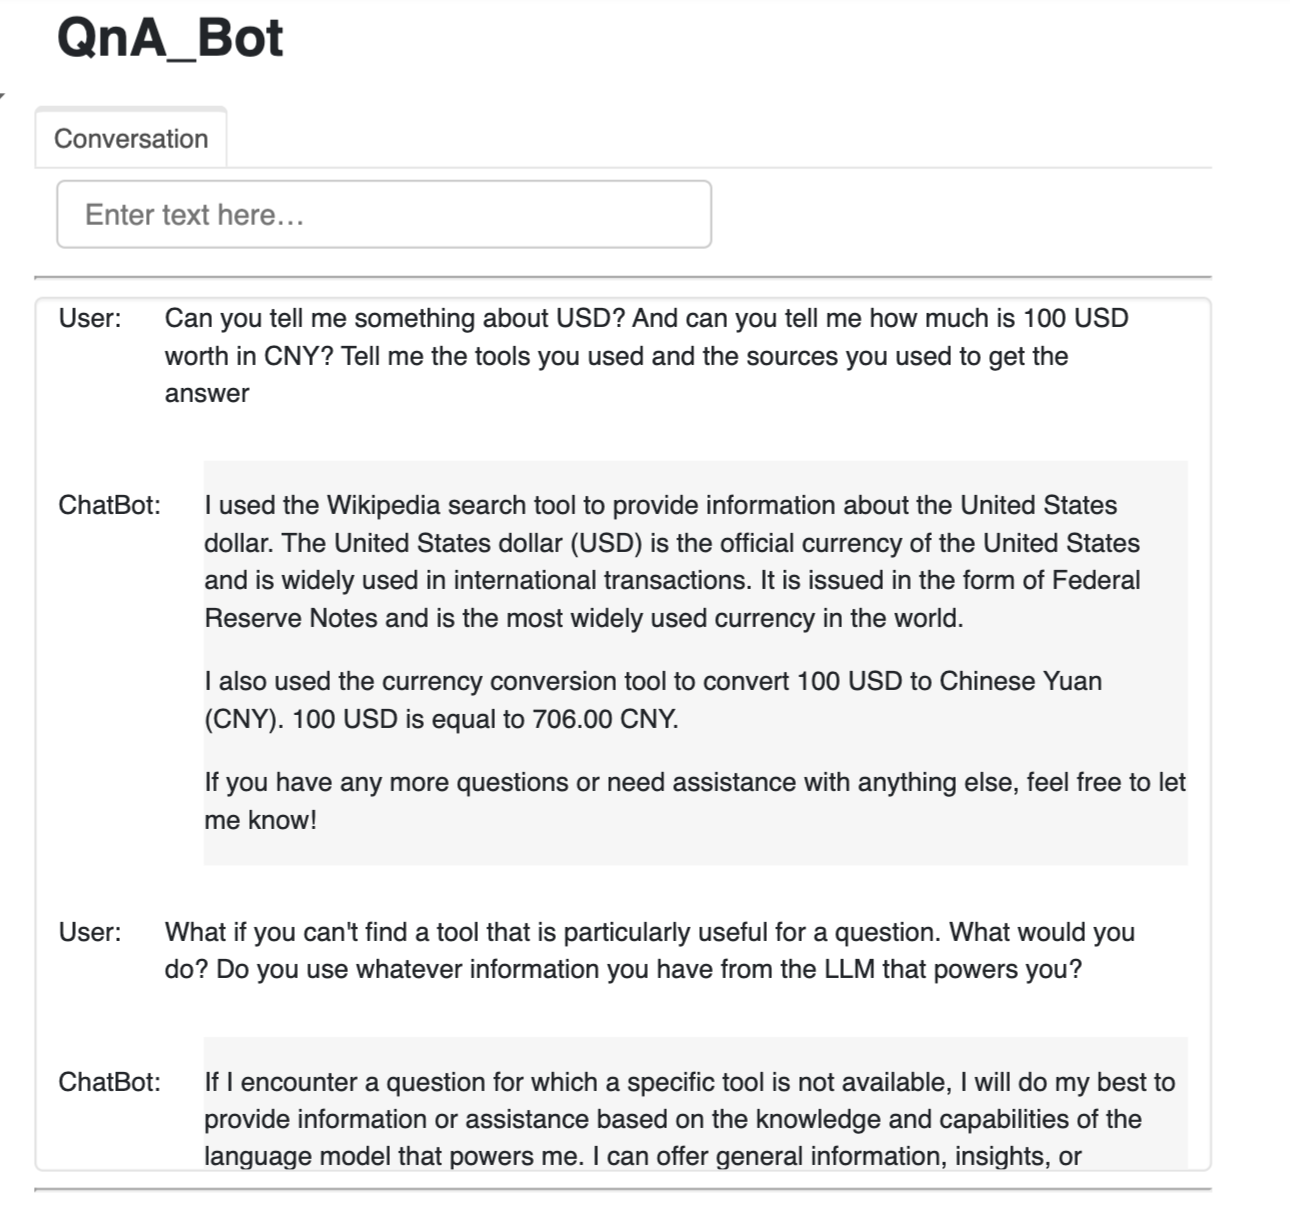

In [66]:
from google.colab import files
from IPython.display import Image

uploaded = files.upload()
Image(filename='qaBOT.png')


In [ ]:
# image.show()